### 1. Здійсніть імпорт необхідних пакетів.

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import fetch_california_housing


### 2. Завантажте набір даних California Housing, як це показано у розділі «Практика застосування лінійної регресії. EDA датасету California Housing» теми «Лінійна регресія. Оцінка якості регресії».

In [6]:
# Завантаження набору даних
data = fetch_california_housing(as_frame=True)
df = data.frame

# Виведення перших рядків для перевірки
print(df.head())


   MedInc  HouseAge  AveRooms  ...  Latitude  Longitude  MedHouseVal
0  8.3252      41.0  6.984127  ...     37.88    -122.23        4.526
1  8.3014      21.0  6.238137  ...     37.86    -122.22        3.585
2  7.2574      52.0  8.288136  ...     37.85    -122.24        3.521
3  5.6431      52.0  5.817352  ...     37.85    -122.25        3.413
4  3.8462      52.0  6.281853  ...     37.85    -122.25        3.422

[5 rows x 9 columns]


### 3. Виконайте етапи з додаткової обробки даних, а саме:

#### 3.1. Проведіть очистку від викидів для колонок AveRooms, AveBedrms, AveOccup та Population, розглянутих у тому ж розділі теми у блоці «Розподіл ознак».

In [7]:
# Колонки для очистки
columns_to_clean = ['AveRooms', 'AveBedrms', 'AveOccup', 'Population']

In [10]:
from scipy.stats import zscore

# Обчислення Z-скорів для колонок
z_scores = df[columns_to_clean].apply(zscore)

# Створення маски для аномальних значень
mask = (z_scores.abs() > 3).any(axis=1)

# Видалення аномальних рядків
df_cleaned = df[~mask]

# Перевірка результатів
print(f"Розмір початкового набору даних: {df.shape}")
print(f"Розмір набору після очистки: {df_cleaned.shape}")


Розмір початкового набору даних: (20640, 9)
Розмір набору після очистки: (20135, 9)


#### 3.2. Видаліть із набору даних одну ознаку із тих, які мають високу кореляцію між собою.

#### Аналіз матриці кореляції

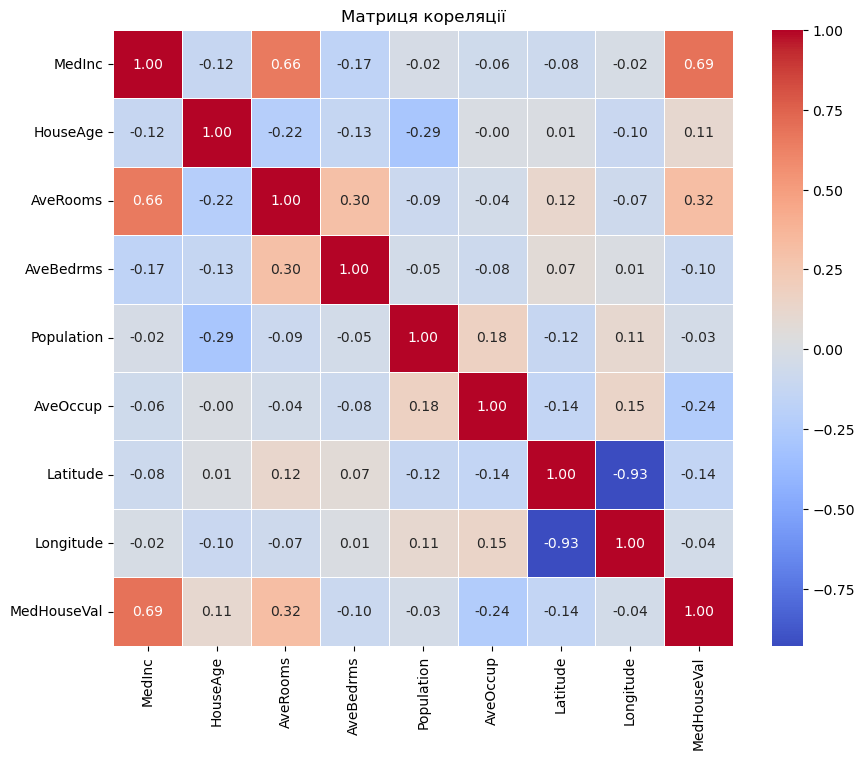

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Побудова теплової карти кореляції
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Матриця кореляції")
plt.show()



#### Рішення:
- Якщо ми орієнтуємося на видалення сильно скорельованих ознак:
Видаляємо Longitude, залишаючи Latitude, оскільки кореляція між ними (-0.93) є найбільш значущою.


In [18]:
# Видалення ознаки Longitude
df_final = df_cleaned.drop(columns=['Longitude'])

# Перевірка розміру набору даних після видалення
print(f"Розмір набору після видалення ознаки Longitude: {df_final.shape}")

# Виведення перших рядків для перевірки
print(df_final.head())


Розмір набору після видалення ознаки Longitude: (20135, 8)
   MedInc  HouseAge  AveRooms  ...  AveOccup  Latitude  MedHouseVal
0  8.3252      41.0  6.984127  ...  2.555556     37.88        4.526
1  8.3014      21.0  6.238137  ...  2.109842     37.86        3.585
2  7.2574      52.0  8.288136  ...  2.802260     37.85        3.521
3  5.6431      52.0  5.817352  ...  2.547945     37.85        3.413
4  3.8462      52.0  6.281853  ...  2.181467     37.85        3.422

[5 rows x 8 columns]


### 4. Розбийте вхідний набір даних на навчальну і тестову вибірки за допомогою методу train_test_split() з пакета sklearn.



In [19]:
from sklearn.model_selection import train_test_split

# Розділення на ознаки (X) та цільову змінну (y)
X = df_final.drop(columns=['MedHouseVal'])  # 'MedHouseVal' - це цільова змінна
y = df_final['MedHouseVal']

# Розділення на навчальну (80%) і тестову (20%) вибірки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Перевірка розмірів отриманих вибірок
print(f"Розмір X_train: {X_train.shape}")
print(f"Розмір X_test: {X_test.shape}")
print(f"Розмір y_train: {y_train.shape}")
print(f"Розмір y_test: {y_test.shape}")


Розмір X_train: (16108, 7)
Розмір X_test: (4027, 7)
Розмір y_train: (16108,)
Розмір y_test: (4027,)


### 5. Здійсніть нормалізацію ознак за допомогою об’єкту StandardScaler з пакета sklearn.

In [20]:
from sklearn.preprocessing import StandardScaler

# Ініціалізація StandardScaler
scaler = StandardScaler()

# Нормалізація ознак навчальної вибірки
X_train_scaled = scaler.fit_transform(X_train)

# Нормалізація ознак тестової вибірки (використовуємо ті ж параметри, що й для навчальної)
X_test_scaled = scaler.transform(X_test)

# Перевірка результату
print("Перші 5 рядків X_train_scaled:")
print(X_train_scaled[:5])

print("Перші 5 рядків X_test_scaled:")
print(X_test_scaled[:5])


Перші 5 рядків X_train_scaled:
[[-0.79409774 -0.95778945 -0.96204644  0.65102244  0.79293381 -0.79571603
  -0.72435721]
 [ 0.23574572  1.60837019  0.14546532  0.03999964  0.11485459 -0.95353419
  -0.75245666]
 [-0.42976856  0.72625281 -0.2815675  -0.85886619 -0.01289947  1.44329107
   0.85389531]
 [-0.83923074 -0.39644203 -1.8591016   0.23232134  1.34571579 -0.10968911
   0.86326179]
 [ 0.40590293  0.40548286 -0.43974588 -1.12445716 -1.04475915  0.54146363
  -0.8133388 ]]
Перші 5 рядків X_test_scaled:
[[-0.08924349  1.04702277  0.00248998  0.7861537  -0.87646775 -0.2086859
  -0.83207177]
 [ 0.17913198  1.20740774  0.02319786 -1.12104772 -0.6086756  -0.66430934
   0.85389531]
 [-0.7444883   0.56586783 -0.98418923  0.64233277 -0.65412656  0.86107745
  -0.87890419]
 [-0.01920044 -1.59932937 -0.44258526  0.83352889 -1.18479725 -1.54733499
   0.89604448]
 [-0.99390475  1.04702277 -0.03203104  0.07851373  0.93788553  0.45263457
  -0.80865556]]


### 6. Побудуйте модель за допомогою об’єкту LinearRegression з пакета sklearn.

In [21]:
from sklearn.linear_model import LinearRegression

# Ініціалізація моделі лінійної регресії
model = LinearRegression()

# Навчання моделі на нормалізованих даних
model.fit(X_train_scaled, y_train)

# Виведення коефіцієнтів та вільного члену
print("Коефіцієнти моделі (weights):", model.coef_)
print("Вільний член моделі (bias):", model.intercept_)


Коефіцієнти моделі (weights): [ 1.02725078  0.2081107  -0.30513361  0.16786281  0.05770346 -0.23114384
 -0.08604137]
Вільний член моделі (bias): 2.070842966227961


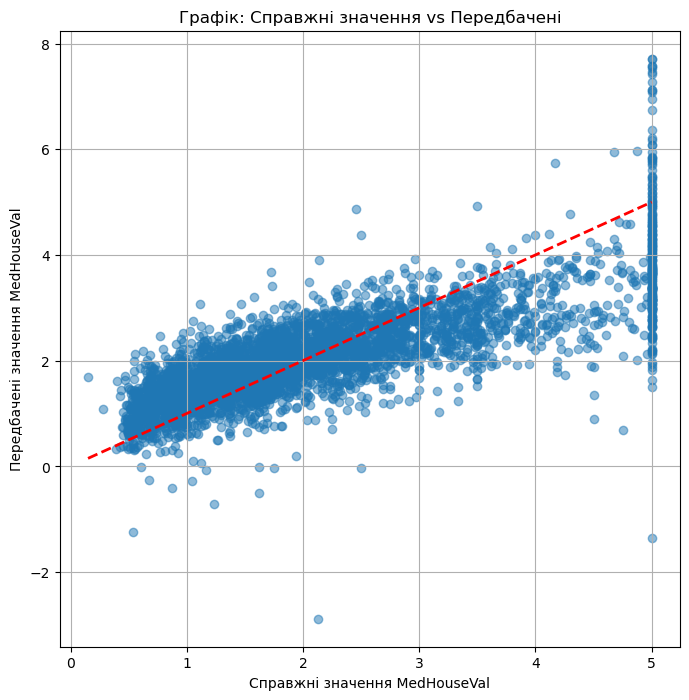

In [22]:

# Передбачення значень на тестових даних
y_pred = model.predict(X_test_scaled)

# Побудова графіка
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', linewidth=2)  # Лінія y = x
plt.xlabel("Справжні значення MedHouseVal")
plt.ylabel("Передбачені значення MedHouseVal")
plt.title("Графік: Справжні значення vs Передбачені")
plt.grid()
plt.show()


In [23]:
from sklearn.metrics import mean_squared_error, r2_score

# Обчислення передбачень
y_pred = model.predict(X_test_scaled)

# Обчислення MSE та R²
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")


Mean Squared Error (MSE): 0.5464
R-squared (R²): 0.6062


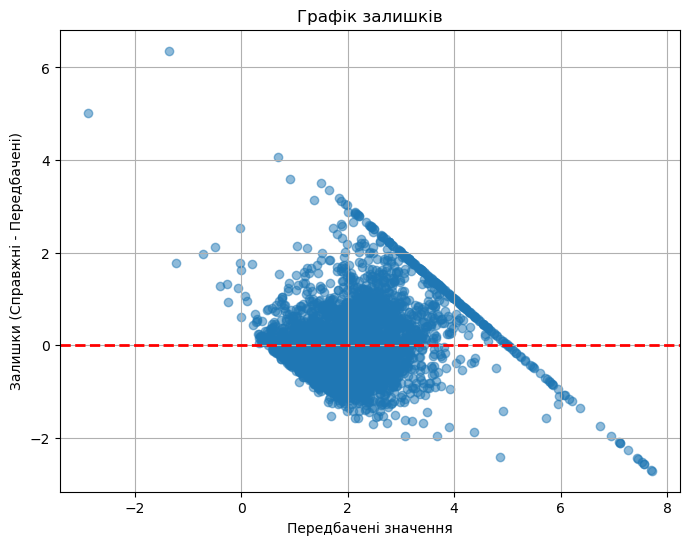

In [24]:
# Обчислення залишків
residuals = y_test - y_pred

# Побудова графіка залишків
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Передбачені значення")
plt.ylabel("Залишки (Справжні - Передбачені)")
plt.title("Графік залишків")
plt.grid()
plt.show()


### 7. Оцініть показники моделі:

- R-квадрат (коефіцієнт детермінації);
- MAE (середня абсолютна похибка);
- MAPE (cередня абсолютна похибка у відсотках).

In [26]:
from sklearn.metrics import mean_absolute_error

# Обчислення R-квадрат
r2 = r2_score(y_test, y_pred)

# Обчислення MAE (середньої абсолютної похибки)
mae = mean_absolute_error(y_test, y_pred)

# Обчислення MAPE (середньої абсолютної похибки у відсотках)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

# Виведення результатів
print(f"R-квадрат (R²): {r2:.4f}")
print(f"Середня абсолютна похибка (MAE): {mae:.4f}")
print(f"Середня абсолютна похибка у відсотках (MAPE): {mape:.2f}%")


R-квадрат (R²): 0.6062
Середня абсолютна похибка (MAE): 0.5437
Середня абсолютна похибка у відсотках (MAPE): 32.54%


### 8. Порівняйте нові метрики з метриками моделі, отриманими в розділі «Практика застосування лінійної регресії. Оцінювання точності моделі» теми «Лінійна регресія. Оцінка якості регресії.», зробіть висновки.

## R2: 0.61 | MAE: 0.52 | MAPE: 0.31

### Висновки:
- R²:

    У мене R² = 0.6062, що трохи нижче, ніж у конспекті (0.61). Це свідчить, що моя модель пояснює трохи менше варіації в даних, ніж у прикладі з конспекту.
- MAE:

    У мене MAE = 0.5437, що більше, ніж у конспекті (0.52). Це означає, що середня абсолютна похибка моїх передбачень вища.
- MAPE:

    У мене MAPE = 32.54%, що також значно більше, ніж у конспекті (31%). Це вказує на більший середній відсоток помилок у моїх передбаченнях.


### Головне що відмінності в метриках між моїй моделлю та прикладом з конспекту є незначними і не критичними.